In [24]:
import boto3
import io
import pandas as pd

import seaborn as sns

from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
boto3.setup_default_session(profile_name='personal')

# Input data checks

In [3]:
client = boto3.client('s3')
response = client.list_objects_v2(
    Bucket='prj001-baby',
    #Delimiter='/',
    EncodingType='url',
    MaxKeys=123,
    #Prefix='raw',
    #ContinuationToken='string',
    #FetchOwner=True|False,
    StartAfter='data/001/raw',
    #RequestPayer='requester'
)
#print(response)
for o in response.get('Contents'):
    print (o.get('Key') + ' ' + str(o.get('Size')/ 1000) + ' kb' )
    

data/001/raw/ 0.0 kb
data/001/raw/excretions.csv 54.392 kb
data/001/raw/feeds.csv 219.83 kb
data/001/raw/growths.csv 0.064 kb
data/001/raw/journal_entries.csv 1.209 kb
data/001/raw/medicine_records.csv 0.347 kb
data/001/raw/medicines.csv 0.171 kb
data/001/raw/pauses.csv 0.47 kb
data/001/raw/pumpings.csv 0.171 kb
data/001/raw/sleeps.csv 2.662 kb
data/001/raw/teeths.csv 0.033 kb
data/001/raw/temperatures.csv 0.045 kb
data/001/raw/vaccinations.csv 0.166 kb


## Feed data

In [4]:
boto3.setup_default_session(profile_name='personal')
s3 = boto3.client('s3')
obj = s3.get_object(Bucket='prj001-baby', Key='data/001/raw/feeds.csv')
df = pd.read_csv(io.BytesIO(obj['Body'].read()))

Most column names have been prefixed with a space

In [5]:
df.columns

Index(['id', ' Start Time', ' End Time', ' Feed Type', ' Quantity (oz)',
       ' Quantity (ml or g)', ' Notes', ' Duration (Minutes)', ' Food Type',
       ' Unit', ' Bottle Type'],
      dtype='object')

There are some odd feed durations. I left the stopwatch running because I was sleep deprived

In [6]:
df.describe()

,id,Quantity (oz),Quantity (ml or g),Duration (Minutes)
count,2530.000000,2530.000000,2530.000000,2530.000000
mean,1281.190909,3.702921,109.503953,10.089328
std,736.290294,1.490045,44.078153,16.122993
min,2.000000,0.340000,10.000000,0.000000
25%,644.250000,2.540000,75.000000,8.000000
50%,1280.500000,3.380000,100.000000,9.000000
75%,1919.750000,5.070000,150.000000,10.000000
max,2554.000000,9.300000,275.000000,729.000000


In [7]:
df.tail(10)

,id,Start Time,End Time,Feed Type,Quantity (oz),Quantity (ml or g),Notes,Duration (Minutes),Food Type,Unit,Bottle Type
2520,11,12:18:38 04-27-2017,12:30:06 04-27-2017,Bottle,2.03,60,NaN,11,Liquid,METRIC,Formula
2521,10,09:26:41 04-27-2017,09:34:51 04-27-2017,Bottle,2.03,60,NaN,8,Liquid,METRIC,Formula
2522,9,05:43:08 04-27-2017,05:50:00 04-27-2017,Bottle,2.03,60,NaN,6,Liquid,METRIC,Formula
2523,8,02:23:50 04-27-2017,02:27:37 04-27-2017,Bottle,2.03,60,NaN,3,Liquid,METRIC,Formula
2524,7,22:51:30 04-26-2017,22:57:41 04-26-2017,Bottle,2.03,60,NaN,6,Liquid,METRIC,Formula
2525,6,20:21:56 04-26-2017,20:23:31 04-26-2017,Bottle,2.03,60,NaN,1,Liquid,METRIC,Formula
2526,5,17:04:20 04-26-2017,17:08:18 04-26-2017,Bottle,2.03,60,NaN,3,Liquid,METRIC,Formula
2527,4,14:30:46 04-26-2017,14:42:48 04-26-2017,Bottle,2.03,60,NaN,12,Liquid,METRIC,Formula
2528,3,11:55:10 04-26-2017,12:00:48 04-26-2017,Bottle,2.03,60,NaN,5,Liquid,METRIC,Formula
2529,2,09:00:46 04-26-2017,09:09:48 04-26-2017,Bottle,2.03,60,NaN,9,Liquid,METRIC,Formula


In [8]:
print(df.shape)

(2530, 11)


In [9]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2530 entries, 0 to 2529
Data columns (total 11 columns):
id                     2530 non-null int64
 Start Time            2530 non-null object
 End Time              2530 non-null object
 Feed Type             2530 non-null object
 Quantity (oz)         2530 non-null float64
 Quantity (ml or g)    2530 non-null int64
 Notes                 82 non-null object
 Duration (Minutes)    2530 non-null int64
 Food Type             2529 non-null object
 Unit                  2530 non-null object
 Bottle Type           2483 non-null object
dtypes: float64(1), int64(3), object(7)
memory usage: 217.5+ KB
None


## Time range of feeds 

In [15]:
df[' Start Time'] = df[' Start Time'].astype('datetime64')

In [13]:
start_date = min(df[' Start Time'])
end_date = max(df[' Start Time']) 

The earliest feed happens on {{start_date}} 
The final feed happens on {{end_date}}

At some point we started feeding solid food

In [23]:
df[' Food Type'].unique()

array(['Liquid', 'Yogurt', 'Vege', 'Dairy', 'Bread; Fruit; Yogurt',
       'Meat; Vege', 'Fruit; Yogurt', 'Cereal', 'Fruit',
       'Bread; Fruit; Vege', 'Meat', nan, 'Bread; Dairy; Fruit',
       'Fruit; Vege', 'Bread; Fruit', 'Fruit; Meat', 'Bread'],
      dtype=object)

## A small number of feeds are not bottle feeds

In [14]:
df[' Bottle Type'].unique()

array(['Formula', nan], dtype=object)

These are the times when solid feeds were down

In [20]:
df[df[' Bottle Type'].isnull()][' Food Type'].unique()

array(['Liquid', 'Yogurt', 'Vege', 'Dairy', 'Bread; Fruit; Yogurt',
       'Meat; Vege', 'Fruit; Yogurt', 'Cereal', 'Fruit',
       'Bread; Fruit; Vege', 'Meat', nan, 'Bread; Dairy; Fruit',
       'Fruit; Vege', 'Bread; Fruit', 'Fruit; Meat', 'Bread'],
      dtype=object)

## Quantity of Feed

In [30]:
my_palette = ['#78C850',  # Grass
                    '#F08030',  # Fire
                    '#6890F0',  # Water
                    '#A8B820',  # Bug
                    '#A8A878',  # Normal
                    '#A040A0',  # Poison
                    '#F8D030',  # Electric
                    '#E0C068',  # Ground
                    '#EE99AC',  # Fairy
                    '#C03028',  # Fighting
                    '#F85888',  # Psychic
                    '#B8A038',  # Rock
                    '#705898',  # Ghost
                    '#98D8D8',  # Ice
                    '#7038F8',  # Dragon
                   ]

In [35]:
max_quantity = max(df[' Quantity (ml or g)'] )

275

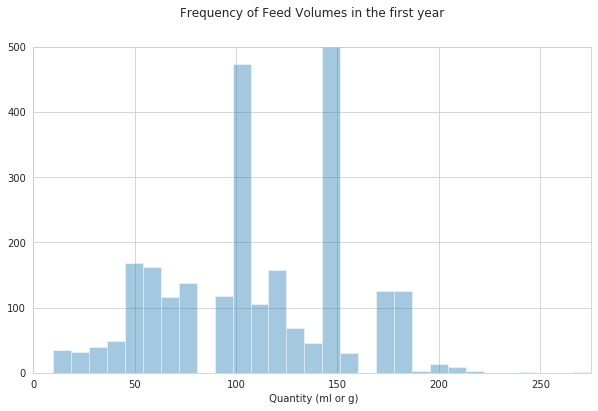

In [53]:
sns.set_style('whitegrid')
plt.figure(figsize=(10,6))
 
ax1 = sns.distplot(df[' Quantity (ml or g)'] , kde=False, bins = 30)
plt.ylim(0, 500)
plt.xlim(0, max_quantity)


ax1.set_title('Frequency of Feed Volumes in the first year', pad=30)

plt.show()

In [34]:
	
# Joint Distribution Plot
sns.jointplot(x=' Start Time', y=' Quantity (ml or g)', data=df)

TypeError: can't multiply sequence by non-int of type 'float'

Error in callback <function flush_figures at 0x7f6011147510> (for post_execute):


KeyboardInterrupt: 